In [1]:
# Display settings
## Auto reload modules & inline plots
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dt #For inputing any date or time information
from datetime import timezone #For inputing timezones
from google.cloud import bigquery          #The BigQuery API
import matplotlib.pyplot as plt      #For plotting
import numpy as np                         #For scientific computation
import os                            #For work with native operating system and directories
from pathlib import Path             #For working with file paths and directories
import pydata_google_auth                  #For authentication against Google 
import pandas as pd                        #For data manipulation and bgq --> pandas conversion
import pandas_gbq as pd_gbq #Import BigQuery data to create a pandas dataframe
import plotly.graph_objects as go # interactive plots
import pytz #For timezone calculations
import seaborn as sns                #For plotting
import warnings
import datetime

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

In [4]:
query = """
SELECT
  CUSTOMER_NUMBER,
  ENTERPRISE_ACCOUNT_NO,
  ENTERPRISE_ACCOUNT_NAME,
  NATIONAL_ACCOUNT,
  PAYER,
  DOCUMENT_DATE_IN_DOCUMENT,
  DOCUMENT_TYPE,
  POSTING_KEY_NAME,
  AMOUNT_IN_LOCAL_CURRENCY,
  CREDIT_CONTROL_AREA,
  AR_STATUS,
  PAYMENT_DATE
  
FROM
  `edna-data-pr-cah.VW_CORP_GFSS_NP.VW_AR_AGING`
WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))
ORDER BY
  PAYMENT_DATE
"""

<font color='red'>check on: WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))</font> 

In [5]:
# Import the data with imputation
bqclient = bigquery.Client()
df = bqclient.query(query).to_dataframe()

In [6]:
df

,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE
0,0031002280,,,,None,2021-04-27,DH,16 - Payment difference,-110.820000000,Z2140,CLEAR,None
1,0031004394,7100000234,7100000234 - NEW YORK PRESBYTERIAN HEALTHCARE ...,,None,2021-04-09,DH,06 - Payment difference,282.110000000,Z2140,CLEAR,None
2,0031004394,7100000234,7100000234 - NEW YORK PRESBYTERIAN HEALTHCARE ...,,None,2021-04-23,DH,06 - Payment difference,202.220000000,Z2140,CLEAR,None
3,0031004394,7100000234,7100000234 - NEW YORK PRESBYTERIAN HEALTHCARE ...,,None,2021-04-20,DL,16 - Payment difference,-454.070000000,Z2140,CLEAR,None
4,0010012413,7100017231,7100017231 - University of Missouri System,,None,2021-09-23,DH,06 - Payment difference,150.000000000,Z2140,CLEAR,None
...,...,...,...,...,...,...,...,...,...,...,...,...
53259959,2057223688,7100000645,7100000645 - UNIV OF MIAMI HEALTH SYSTEM,0000027009,2057223688,2203-06-21,DL,17 - Other clearing,-113370.440000000,PD,CLEAR,2203-06-21
53259960,0011098170,7100004978,7100004978 - ASC CENTER FOR CHANGE LLC,,None,2222-04-26,DL,06 - Payment difference,376.180000000,Z2140,CLEAR,2222-04-26
53259961,0011098170,7100004978,7100004978 - ASC CENTER FOR CHANGE LLC,,None,2222-04-26,DL,16 - Payment difference,-376.180000000,Z2140,CLEAR,2222-04-26
53259962,0010011780,7100000117,7100000117 - AVERA HEALTH,,None,5019-05-25,DL,17 - Other clearing,-328.000000000,Z2140,CLEAR,5019-05-25


In [7]:
def calc_WAPD(df):
    WAPD_new = pd.Series([])
    for index, row in df.iterrows():
        start_date= row['PAYMENT_DATE']
        end_date = row['90_days_ago']
        try:
            ninety_day_range = df.query('@start_date >= PAYMENT_DATE >= @end_date')
            WAPD= ninety_day_range['Weighted Invoice Value'].sum()/ninety_day_range['AMOUNT_IN_LOCAL_CURRENCY'].sum()
            WAPD_new[index]=WAPD
        except:
            print('no PAYMENT_DATE')
    df.insert(16, "WAPD", WAPD_new)

In [8]:
def search_customer(CUSTOMER_NUMBER):
    CUSTOMER_df=df.query('CUSTOMER_NUMBER == @CUSTOMER_NUMBER')
    CUSTOMER_df=CUSTOMER_df.query('POSTING_KEY_NAME == "01 - Invoice" & AR_STATUS == "CLEAR"')
    CUSTOMER_df.reset_index(inplace = True)
    
    
    CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']=CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    CUSTOMER_df['Sub Payment Date from Invoice Date']=(CUSTOMER_df['PAYMENT_DATE']-CUSTOMER_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    CUSTOMER_df['Weighted Invoice Value']= CUSTOMER_df['Sub Payment Date from Invoice Date']*CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = CUSTOMER_df['PAYMENT_DATE']
    d = datetime.timedelta(days = 90)
    days_ago = (current - d)
    CUSTOMER_df['90 days ago']= days_ago
    # WAPD_dates = (CUSTOMER_df['PAYMENT_DATE'] > CUSTOMER_df['90 days ago'][0]) & (CUSTOMER_df['PAYMENT_DATE'] <= CUSTOMER_df['PAYMENT_DATE'][0])
    # df2 = CUSTOMER_df.loc[WAPD_dates]
    
    calc_WAPD(CUSTOMER_df)

    return CUSTOMER_df

In [9]:
def search_EAN(ENTERPRISE_ACCOUNT_NAME):
    None

In [10]:
def search_EAN(ENTERPRISE_ACCOUNT_NAME):
    None

# **********************************************************************************************************

In [11]:
CONVERSIO_HEALTH_df=df.query('CUSTOMER_NUMBER == "2057194397"')

In [12]:
CONVERSIO_HEALTH_df=CONVERSIO_HEALTH_df.query('POSTING_KEY_NAME == "01 - Invoice" & AR_STATUS == "CLEAR"')

In [13]:
CONVERSIO_HEALTH_df.isnull().sum()

CUSTOMER_NUMBER              0
ENTERPRISE_ACCOUNT_NO        0
ENTERPRISE_ACCOUNT_NAME      0
NATIONAL_ACCOUNT             0
PAYER                        0
DOCUMENT_DATE_IN_DOCUMENT    0
DOCUMENT_TYPE                0
POSTING_KEY_NAME             0
AMOUNT_IN_LOCAL_CURRENCY     0
CREDIT_CONTROL_AREA          0
AR_STATUS                    0
PAYMENT_DATE                 2
dtype: int64

In [14]:
CONVERSIO_HEALTH_df.reset_index(inplace = True)

In [15]:
# CONVERSIO_HEALTH_df[''] = float(CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY'])
CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY']=CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))

In [16]:
CONVERSIO_HEALTH_df.query('2179.26 >=AMOUNT_IN_LOCAL_CURRENCY >= 2178.26')

,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE
478,46838414,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-06-29,ZF,01 - Invoice,2179.2600,PD,CLEAR,2023-07-21
527,51134561,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-07-28,ZF,01 - Invoice,2179.2600,PD,CLEAR,2023-08-25


### Sub Payment Date from Invoice Date 

In [17]:
CONVERSIO_HEALTH_df['Sub Payment Date from Invoice Date']=(CONVERSIO_HEALTH_df['PAYMENT_DATE']-CONVERSIO_HEALTH_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days

### Weighted Invoice Value

In [18]:
CONVERSIO_HEALTH_df['Weighted Invoice Value']= CONVERSIO_HEALTH_df['Sub Payment Date from Invoice Date']*CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY']

### WAPD 

=SUM(*Weighted Invoice Value* 8:AR15)/SUM(*AMOUNT_IN_LOCAL_CURRENCY* 8:AS15)

In [19]:
# CONVERSIO_HEALTH_df['WAPD']= CONVERSIO_HEALTH_df['Weighted Invoice Value']/CONVERSIO_HEALTH_df['AMOUNT_IN_LOCAL_CURRENCY']

In [20]:
import datetime
current = pd.to_datetime(CONVERSIO_HEALTH_df['PAYMENT_DATE'])
CONVERSIO_HEALTH_df['90_days_ago']= current - pd.to_timedelta('90 days')

In [22]:
CONVERSIO_HEALTH_df['PAYMENT_DATE']=pd.to_datetime(CONVERSIO_HEALTH_df['PAYMENT_DATE'])

In [42]:
# CONVERSIO_HEALTH_df.query('"2022-10-14" >= PAYMENT_DATE >= "2022-07-16"')

In [26]:
WAPD_new = pd.Series([])
for index, row in CONVERSIO_HEALTH_df.iterrows():
    start_date= row['PAYMENT_DATE']
    end_date = row['90_days_ago']
    try:
        ninety_day_range = CONVERSIO_HEALTH_df.query('@start_date >= PAYMENT_DATE >= @end_date')
        WAPD= ninety_day_range['Weighted Invoice Value'].sum()/ninety_day_range['AMOUNT_IN_LOCAL_CURRENCY'].sum()
        WAPD_new[index]=WAPD
    except:
        print('no PAYMENT_DATE')
CONVERSIO_HEALTH_df.insert(16, "WAPD", WAPD_new)

no PAYMENT_DATE
no PAYMENT_DATE


# Visualization

## Customer

In [32]:
df['CUSTOMER_NUMBER'].unique()

array(['0031002280', '0031004394', '0010012413', ..., '2057183654',
       '2057158691', '0010015540'], dtype=object)

In [33]:
customer = "2057194397"
# t = search_customer(customer)

In [41]:
CONVERSIO_HEALTH_df['month'] = CONVERSIO_HEALTH_df['PAYMENT_DATE'].dt.strftime('%b')

In [35]:
# plt.bar(CONVERSIO_HEALTH_df['month'],CONVERSIO_HEALTH_df['WAPD'])

In [38]:
year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp = pd.pivot_table(data=CONVERSIO_HEALTH_df, index=[CONVERSIO_HEALTH_df.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp = dfp.reindex(year_order, axis=1)
dfp

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PAYMENT_DATE,,,,,,,,,,,,
2022.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.2435,29.8647,29.9069,29.9826
2023.0000,30.0828,29.5841,27.5906,24.8068,24.9288,24.9342,26.1582,25.3285,26.5825,NaN,NaN,NaN


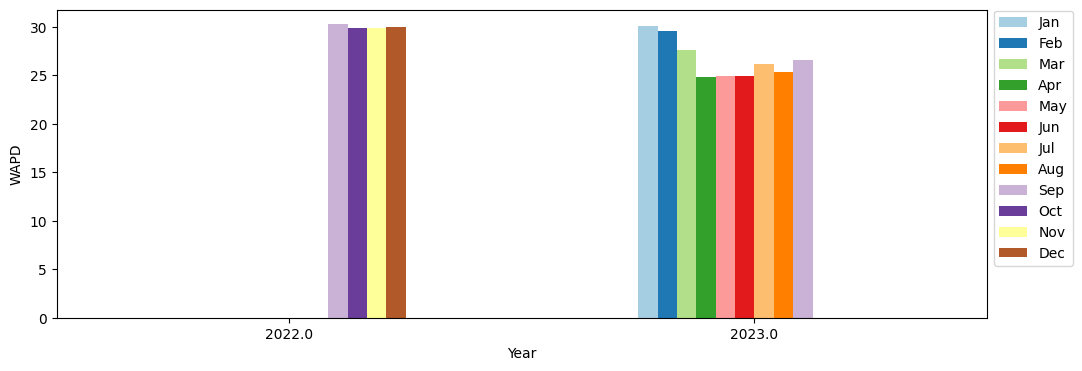

In [40]:
ax = dfp.plot(kind='bar', figsize=(12, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

## EAN

## National Account